In [1]:
!pip install opendatasets

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import warnings
import cv2
import opendatasets
import PIL
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
from tensorflow.keras.layers import Dense, Input, ZeroPadding2D, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.activations import relu, softmax

2024-04-17 12:11:23.177309: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-17 12:11:23.177504: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-17 12:11:23.312173: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
tf.keras.backend.set_image_data_format("channels_last")

In [4]:
##Creating dataset pipeline of tf.dataset from image_dataset_from_directory
train_dataset = image_dataset_from_directory(directory = "/kaggle/input/brain-tumor-mri-dataset/Training",
                                       labels = "inferred",
                                       label_mode = "int",
                                       color_mode = "rgb",
                                       batch_size = 32,
                                       image_size = (145, 145),
                                       shuffle = True,
                                       validation_split = 0.2,
                                       subset = "training",
                                       seed = 30,
                                      )
val_dataset = image_dataset_from_directory(directory = "/kaggle/input/brain-tumor-mri-dataset/Training",
                                           labels = "inferred",
                                           label_mode = "int",
                                           color_mode = "rgb",
                                           batch_size = 32,
                                           image_size = (145, 145),
                                           shuffle = True,
                                           validation_split = 0.2,
                                           subset = "validation",
                                           seed = 30,
                                           )

test_dataset = image_dataset_from_directory(directory = "/kaggle/input/brain-tumor-mri-dataset/Testing",
                                            labels = "inferred",
                                            label_mode = "int",
                                            color_mode = "rgb",
                                            image_size = (145, 145),
                                            shuffle = False
                                            )

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.


In [5]:
print(f"Total classes:= {train_dataset.class_names}")

Total classes:= ['glioma', 'meningioma', 'notumor', 'pituitary']


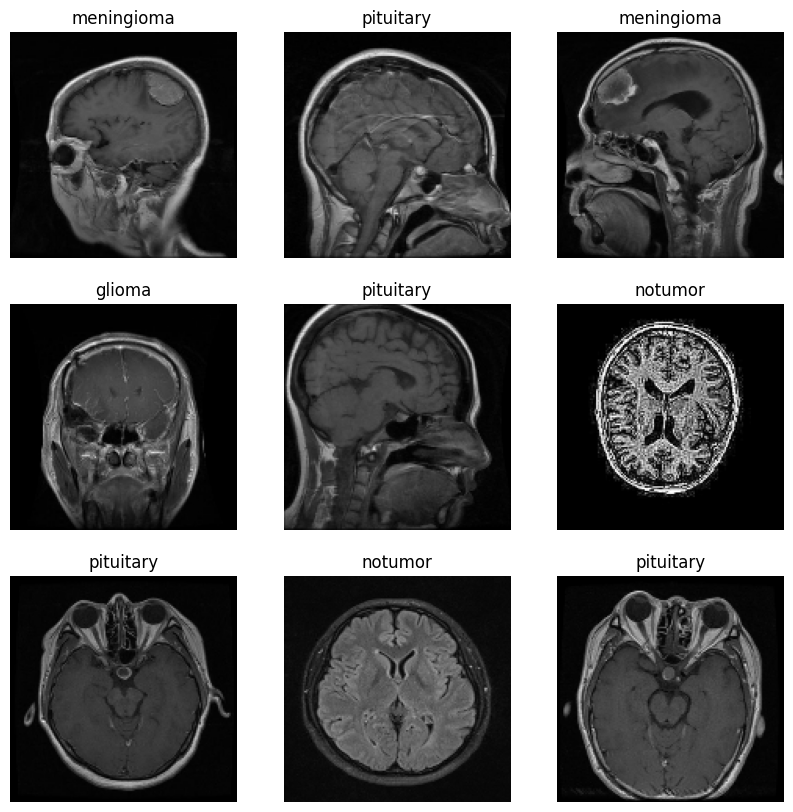

In [6]:
plt.figure(figsize = (10, 10))

for images, label in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy()/255)
    plt.title(train_dataset.class_names[label[i]])
    plt.axis("off")

# Making buffer for faster training

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size = AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size = AUTOTUNE)

# Creating CNN Model

In [8]:
model = Sequential([
    Input((145, 145, 3)),
    tf.keras.layers.Rescaling(scale = 1./255),
    tf.keras.layers.RandomFlip("Horizontal_and_Vertical"),
#     tf.keras.layers.RandomRotation(0.1),
    
    Conv2D(64, 3, strides = (2, 2), activation = "relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides = (2, 2)),
    
    Conv2D(128, 3, padding = "same", activation = "relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides = (2, 2)),
    
    Dropout(0.4),
    Conv2D(256, 3, padding = "same", activation = "relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides = (2, 2)),
    
    Dropout(0.4),
    Conv2D(256, 3, activation = "relu"),
    BatchNormalization(),
    
    Flatten(),
    
    Dropout(0.5),
    Dense(256, activation = "relu"),
    BatchNormalization(),
    Dense(128, activation = "relu"),
    BatchNormalization(),
    Dropout(0.4),
    Dense(64, activation = "relu"),
    BatchNormalization(),
    Dense(4, activation = "linear")
])

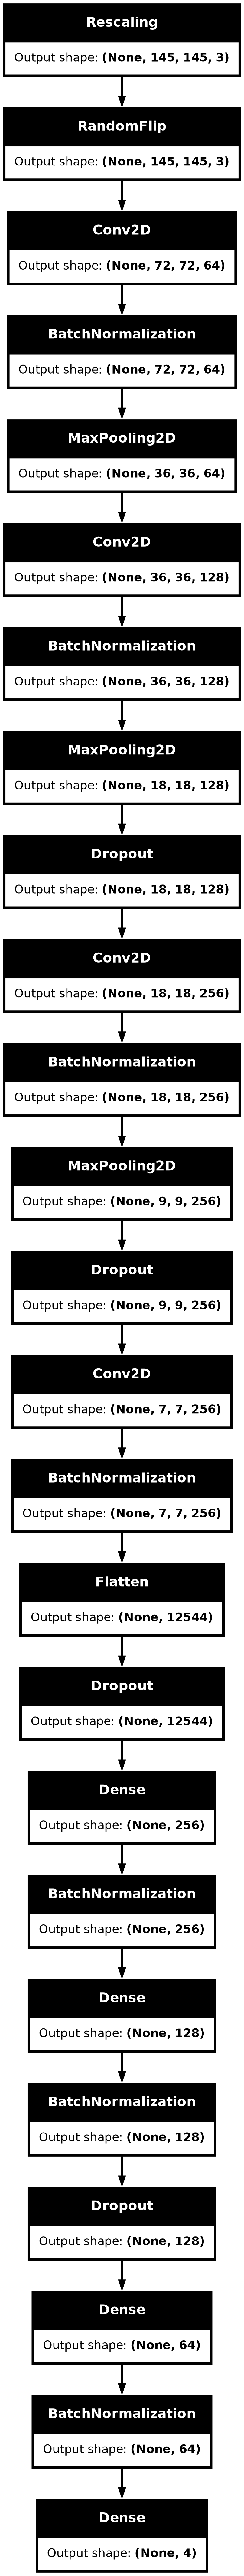

In [9]:
plot_model(model, show_shapes = True,to_file = "model.png")

In [10]:
model.compile(optimizer = "adam", loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), metrics = ["accuracy"])

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 145, 145, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 145, 145, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 72, 72, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 36, 36, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 36, 36, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 18, 18, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,211,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             

 Total params: 4,218,436 (16.09 MB)

 Trainable params: 4,216,132 (16.08 MB)

 Non-trainable params: 2,304 (9.00 KB)

In [12]:
his = model.fit(train_dataset, validation_data = val_dataset, epochs = 15)

Epoch 1/15
  6/143 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.3512 - loss: 1.6776

I0000 00:00:1713355919.730600      80 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


143/143 ━━━━━━━━━━━━━━━━━━━━ 39s 166ms/step - accuracy: 0.6531 - loss: 0.9223 - val_accuracy: 0.2566 - val_loss: 4.0202
Epoch 2/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8166 - loss: 0.5050 - val_accuracy: 0.2811 - val_loss: 3.3869
Epoch 3/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8543 - loss: 0.4073 - val_accuracy: 0.4842 - val_loss: 2.6159
Epoch 4/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8784 - loss: 0.3290 - val_accuracy: 0.6856 - val_loss: 1.0805
Epoch 5/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8931 - loss: 0.2783 - val_accuracy: 0.7925 - val_loss: 0.8384
Epoch 6/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9122 - loss: 0.2212 - val_accuracy: 0.8538 - val_loss: 0.4921
Epoch 7/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9316 - loss: 0.1801 - val_accuracy: 0.9098 - val_loss: 0.3096
Epoch 8/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9436 - loss: 0.1590 - val_accuracy: 0.8

In [13]:
history = his

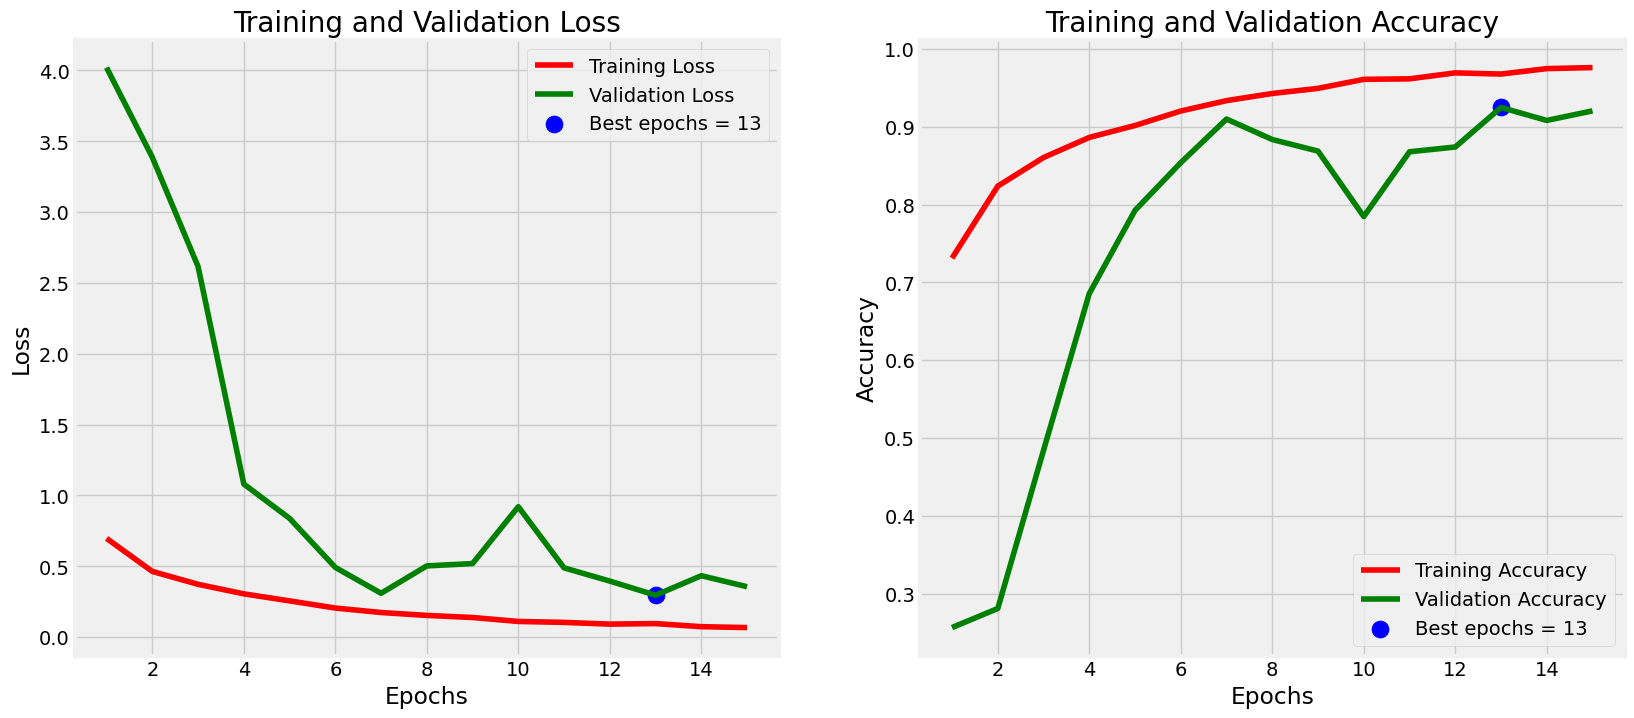

In [14]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue',label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'blue',label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show();

# Model Evaluation

In [15]:
train_score = model.evaluate(train_dataset , verbose = 1)
valid_score = model.evaluate(val_dataset , verbose = 1)
test_score = model.evaluate(test_dataset  , verbose = 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9549 - loss: 0.1550
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9115 - loss: 0.3933
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.8218 - loss: 0.6322
Train Loss:  0.14915752410888672
Train Accuracy:  0.9564551711082458
--------------------
Validation Loss:  0.35585394501686096
Validation Accuracy:  0.9203152656555176
--------------------
Test Loss:  0.4534904658794403
Test Accuracy:  0.8787185549736023


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


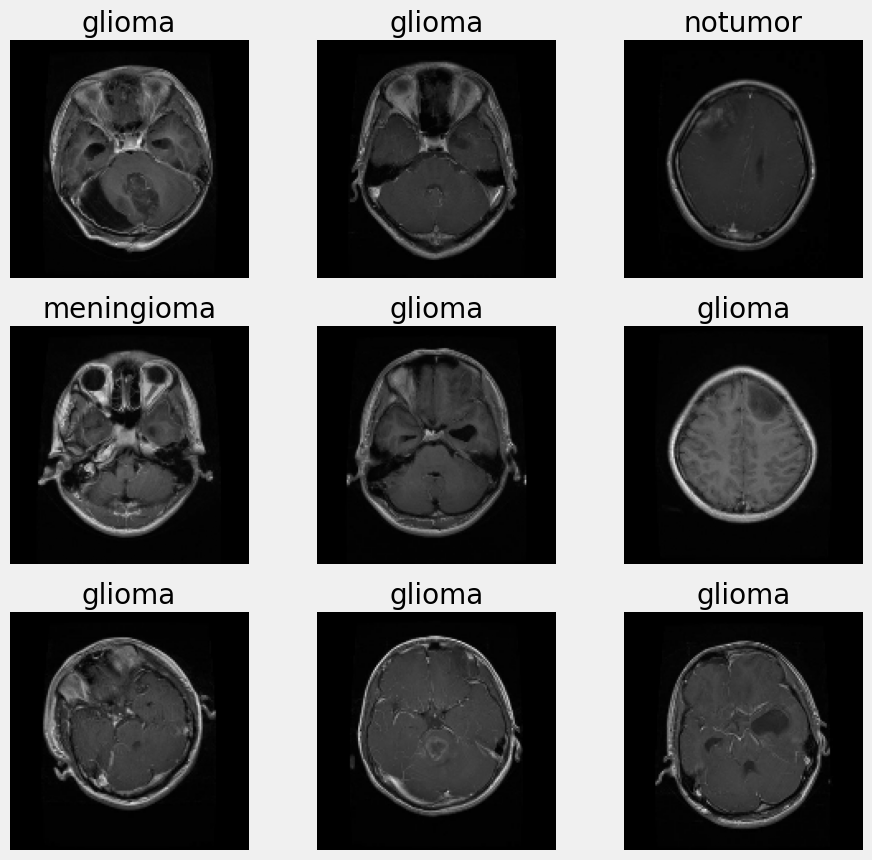

In [16]:
plt.figure(figsize = (10, 10))

images ,labels = next(iter(test_dataset))
name = np.argmax(softmax(model.predict(images)), axis = 1)
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy()/255)
    plt.title(test_dataset.class_names[name[i]])
#     print(name)
    plt.axis("off")

In [17]:
y_true = [(label) for _, label in test_dataset]

In [18]:
y_true = tf.concat(y_true, axis = 0), [-1, 1]

In [19]:
y_pred = np.argmax(softmax(model.predict(test_dataset)), axis = 1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step


0.8787185354691075

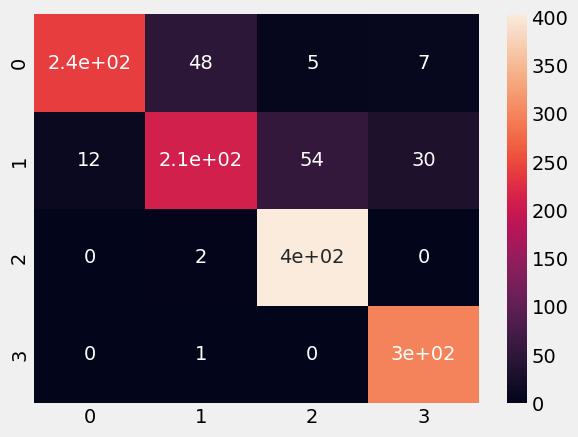

In [20]:
sns.heatmap(confusion_matrix(y_true[0], y_pred), cbar = True, annot = True)
f1_score(y_true[0], y_pred, average = "micro")

In [21]:
model.save("/kaggle/working/Brain_tumor_clw.h5")